# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
print('brain name: {}'.format(brain_name))
print()
print('action space      - size: {:2d} \t(type: {})'.format(brain.vector_action_space_size, brain.vector_action_space_type))
print('observation space - size: {:2d} \t(type: {})'.format(brain.vector_observation_space_size, brain.vector_observation_space_type))

brain name: BananaBrain

action space      - size:  4 	(type: discrete)
observation space - size: 37 	(type: continuous)


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [8]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [9]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [3]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.ddqn_agent import DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='ddqn_epsEnd_002_epsDecay_098_official'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model=dir_models + filename_model





if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)

if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def ddqn(unity_env, path_model, path_log, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE):
    task = Task(unity_env=unity_env)
    agent = DDQN_Agent(task.state_size, task.action_size, seed=seed)

    # Main body of traininig
    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    

    time_start = datetime.now()

    is_print = False
    
    for i_episode in range(1, n_episodes+1):
        
        state = task.reset()
        score = 0.0

        for t in range(max_t):

            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break


        scores_window.append(score)
        scores.append(score)
        
        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # print training message
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode,
                                                                               np.mean(scores_window),
                                                                               datetime.now() - time_start))

            time_start = datetime.now()


        # endding crietrion
        if np.mean(scores_window) >= 13.0 and is_print == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            is_print = True
#             break


    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)
    
    return scores
    

scores = ddqn(eps_end=0.02, eps_decay=0.98, unity_env=env, path_model=path_model, path_log=path_log, n_episodes=n_episodes)

# save scores
with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

Episode 100	Average Score: 2.07, execution time=0:01:20.281506
Episode 200	Average Score: 6.22, execution time=0:01:20.838285
Episode 300	Average Score: 11.48, execution time=0:01:25.220552
Episode 376	 Average Score: 13.04
Environment solved in 276 episodes!	Average Score: 13.04
Episode 400	Average Score: 13.06, execution time=0:01:26.532644
Episode 500	Average Score: 15.19, execution time=0:01:27.052357
Episode 600	Average Score: 15.38, execution time=0:01:26.194458
Episode 700	Average Score: 15.52, execution time=0:01:27.282411
Episode 800	Average Score: 15.43, execution time=0:01:26.093528
Episode 900	Average Score: 16.16, execution time=0:01:25.230312
Episode 1000	Average Score: 16.39, execution time=0:01:28.998553
Episode 1100	Average Score: 16.25, execution time=0:01:27.804786
Episode 1200	Average Score: 15.64, execution time=0:01:28.099685
Episode 1300	Average Score: 15.55, execution time=0:01:29.670619
Episode 1400	Average Score: 14.98, execution time=0:01:34.069898
Episode 15

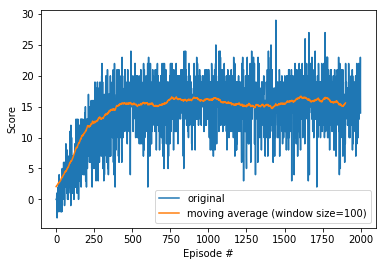

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# load scores from file
scores = pickle.load(open(dir_logs + filename_log, 'rb'))

# calculate moving average
window_size = 100
moving_average = np.convolve(scores, np.ones((window_size,))/window_size, mode='valid')

# plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='original')
plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(window_size))
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Compare Results
The following compare the results between DQN, DDQN, and Dueling DDQN.

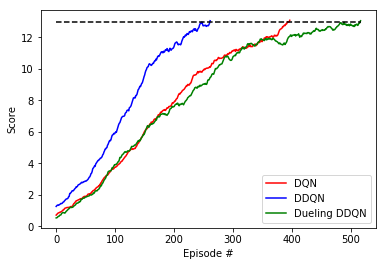

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

from collections import namedtuple
    
def plot_averaged_results(parcels, n_moving_window, alpha=1.0):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
        
    for p in parcels:
        comment, path_log, color = p
        with open(path_log, 'rb') as f:
            scores = pickle.load(f)

        moving_average = np.convolve(scores, np.ones((n_moving_window,))/n_moving_window, mode='valid')

        
#         plt.plot(np.arange(len(scores)), scores, color=color, alpha=alpha)
        plt.plot(np.arange(len(moving_average)), moving_average, 
                 label='{}'.format(comment), 
                 color=color, alpha=alpha)
    

    #draw horizontal line
    plt.plot(np.arange(len(moving_average)), np.ones(len(moving_average)) * 13.0, 'k--')
    
    
    plt.legend()    
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

n_moving_window = 100
LogParcel = namedtuple('LogParcel', ['comment', 'path', 'color'])
logParcels = [LogParcel('DQN', './logs/scores_dqn.pickles', 'r'),
        LogParcel('DDQN', './logs/scores_ddqn_epsEnd_002_epsDecay_098.pickles', 'b'),
        LogParcel('Dueling DDQN', './logs/scores_dueling_ddqn_epsDecay_098_epsEnd_01.pickles', 'g')]

plot_averaged_results(logParcels, n_moving_window)

### Results of free run

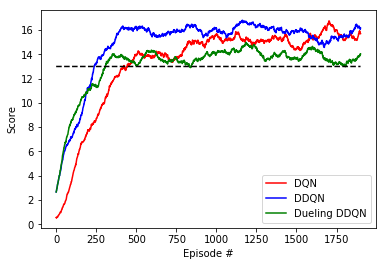

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

from collections import namedtuple
    
def plot_averaged_results(parcels, n_moving_window, alpha=1.0):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
        
    for p in parcels:
        comment, path_log, color = p
        with open(path_log, 'rb') as f:
            scores = pickle.load(f)

        moving_average = np.convolve(scores, np.ones((n_moving_window,))/n_moving_window, mode='valid')

        
#         plt.plot(np.arange(len(scores)), scores, color=color, alpha=alpha)
        plt.plot(np.arange(len(moving_average)), moving_average, 
                 label='{}'.format(comment), 
                 color=color, alpha=alpha)
    

    #draw horizontal line
    plt.plot(np.arange(len(moving_average)), np.ones(len(moving_average)) * 13.0, 'k--')
    
    
    plt.legend()    
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

n_moving_window = 100
LogParcel = namedtuple('LogParcel', ['comment', 'path', 'color'])
logParcels = [LogParcel('DQN', './logs/scores_dqn_free_run.pickles', 'r'),
        LogParcel('DDQN', './logs/scores_ddqn_free_run_epsEnd_002_epsDecay_098.pickles', 'b'),
        LogParcel('Dueling DDQN', './logs/scores_ddqn_epsEnd_01_epsDecay_098_official.pickles', 'g')]

plot_averaged_results(logParcels, n_moving_window)